In [ ]:
import serial
import time
import math
import sympy as sp

# === 설정 ===
# 링크 길이 (cm 등 단위 통일)
L1 = 7.8
L2 = 8.3  # upper arm
L3 = 3.9  # lower arm

# 조인트 가동 범위 (degree)
joint_limits = {
    'theta1': (-30, 210),     # base 회전
    'theta2': (-30, 210),    # shoulder
    'theta3': (-30, 210),     # elbow
}

# === 시리얼 포트 설정 ===
ser = serial.Serial('/dev/arduinoUno', 9600, timeout=1)  # 포트 번호는 환경에 맞게 조정
time.sleep(2)  # 아두이노 초기화 대기



# Forward Kinematics
def fk_3dof(theta1_deg, theta2_deg, theta3_deg):

    # joint_limits = {
    # 'theta1': (-135, 225),     # base 회전
    # 'theta2': (-30, 180),    # shoulder
    # 'theta3': (-135, 200),     # elbow
    # }

    # # 범위 검사
    # input_angles = {'theta1': theta1_deg, 'theta2': theta2_deg, 'theta3': theta3_deg}
    # for name, angle in input_angles.items():
    #     min_angle, max_angle = joint_limits[name]
    #     if not (min_angle <= angle <= max_angle):
    #         return None, f"[오류] {name}={angle:.1f}°: 가동 범위 초과"

    # === 서보 보정 ===
    theta1_deg = theta1_deg - 90
    theta3_deg = 90 - theta3_deg 
    
    # 각도 변환
    t1 = math.radians(theta1_deg)
    t2 = math.radians(theta2_deg)
    t3 = math.radians(theta3_deg)

    # DH 변환행렬 함수
    def dh_transform(theta, d, a, alpha):
        return sp.Matrix([ 
        [sp.cos(theta), -sp.sin(theta)*sp.cos(alpha),  sp.sin(theta)*sp.sin(alpha), a*sp.cos(theta)],
        [sp.sin(theta),  sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha), a*sp.sin(theta)],
        [0,              sp.sin(alpha),                sp.cos(alpha),               d],
        [0,              0,                            0,                           1]
        ])

    # Transformation Matrix
    dh_params = [
    [t1, L1, 0, math.radians(90)],
    [t2, 0, L2, 0],
    [t3, 0, L3, 0],
    ]
    
    T = sp.eye(4)
    for params in dh_params:
        Ti = dh_transform(*params)
        T = T * Ti

    T = sp.simplify(T)
    x = round(T[0, 3], 2)
    y = round(T[1, 3], 2)
    z = round(T[2, 3], 2)


    return (x, y, z), None



# Inverse Kinematics
def ik_3dof(x, y, z):

    # theta1
    if abs(x) < 1e-4 and abs(y) < 1e-4:
        theta1 = 90.0  # 예외 처리
    else:
        theta1 = math.atan2(y, x)
        theta1_deg = math.degrees(theta1)

    theta1_deg = (theta1 + 90) % 360

    # 조인트2 기준으로 평면 거리(r) 및 높이(z_offset)
    r = math.hypot(x, y)
    z_offset = z - L1  # shoulder (조인트2) 기준으로 변환
    d = math.hypot(r, z_offset)

    if d > (L2 + L3):
        return None, "Unreachable: 목표 좌표가 팔 길이보다 멉니다."

    try:
        cos_theta3 = (d**2 - L2**2 - L3**2) / (2 * L2 * L3)
        
        if not -1.0 <= cos_theta3 <= 1.0:
            raise ValueError("Target position is outside the reachable workspace.")
        # theta3
        theta3 = math.atan2(math.sqrt(1-cos_theta3**2),cos_theta3)
        theta3_deg = math.degrees(theta3)
        theta3_deg = (450 - theta3_deg) % 360 # 각보정

        # theta2
        alpha = math.atan2(z_offset, r)
        cos_beta = ((L2**2 + d**2 - L3**2) / (2 * L2 * d))
        beta = math.atan2(math.sqrt(1-cos_beta**2), cos_beta)
        theta2 = alpha + beta
        theta2_deg = math.degrees(theta2)

        # 범위 검사
        # for name, angle in zip(['theta1', 'theta2', 'theta3'], [theta1_deg, theta2_deg, theta3_deg]):
        #     min_angle, max_angle = joint_limits[name]
        #     if not (min_angle <= angle <= max_angle):
        #         return None, f"{name}={angle:.1f}°: 가동 범위 초과"

        return (theta1_deg, theta2_deg, theta3_deg), None

    except ValueError:
        return None, "역삼각법 계산 불가"



# IK coord serial comm
def ik_move(x, y, z):
    result, error = ik_3dof(x, y, z)
    if error:
        print(f"[오류] {error}")
        return
    t1, t2, t3 = result
    
    t1 = int(t1)
    t2 = int(t2)
    t3 = int(t3)

    cmd = f"{t1},{t2},{t3}\n"
    ser.write(cmd.encode())
    time.sleep(0.1)  # 전송 후 지연 추가 (필수)
    print(f"[전송됨] {cmd.strip()}")



# simple_move
def send_move(t1, t2, t3):
    cmd = f"{t1},{t2},{t3}\n"
    ser.write(cmd.encode())
    time.sleep(0.1)  # 전송 후 지연 추가 (필수)
    print(f"[전송됨] {cmd}")

In [44]:
send_move(90,0,180) # angle move

[전송됨] 90,0,180



In [58]:
# FK, angle -> coordinate
result = fk_3dof(45,30,0)
result = result[0]
print(result)

(3.70, -3.70, 15.33)


In [59]:
ik_3dof(result[0],result[1],result[2])

((89.21460183660255, 80.37359418083346, 359.9850688354664), None)

In [60]:
ik_move(result[0],result[1],result[2]) # IK, coordinate -> angle

[전송됨] 89,80,359


In [ ]:
import random
import math

# 로봇팔 링크 길이
L1 = 7.8
L2 = 8.3
L3 = 3.9
MAX_REACH = L2 + L3

def generate_valid_xyz():
    while True:
        # z 범위 내 임의 생성
        z = random.uniform(L1, L1 + MAX_REACH)
        # r은 x, y 평면상의 거리
        r = random.uniform(0, MAX_REACH)

        # 각도 랜덤 (theta1 ∈ [0, 180]) → 반원 내 좌표 생성
        angle_rad = math.radians(random.uniform(0, 180))
        x = r * math.sin(angle_rad)
        y = r * math.cos(angle_rad)

        # 조인트2 기준 거리 d 계산
        z_offset = z - L1
        d = math.hypot(r, z_offset)

        if d <= MAX_REACH:
            return round(x, 2), round(y, 2), round(z, 2)


In [97]:
rand_coord = generate_valid_xyz()
rand_coord

(1.55, -2.05, 14.67)

In [98]:
ik_move(rand_coord[0], rand_coord[1], rand_coord[2])
# 가동범위
# XY 평면 상 반원, L2 + L3 = 12.2
# 높이, min : L1 = 7.8 / max = L1 + L2 + L3 = 20

[오류] theta3=-27.9°: 가동 범위 초과


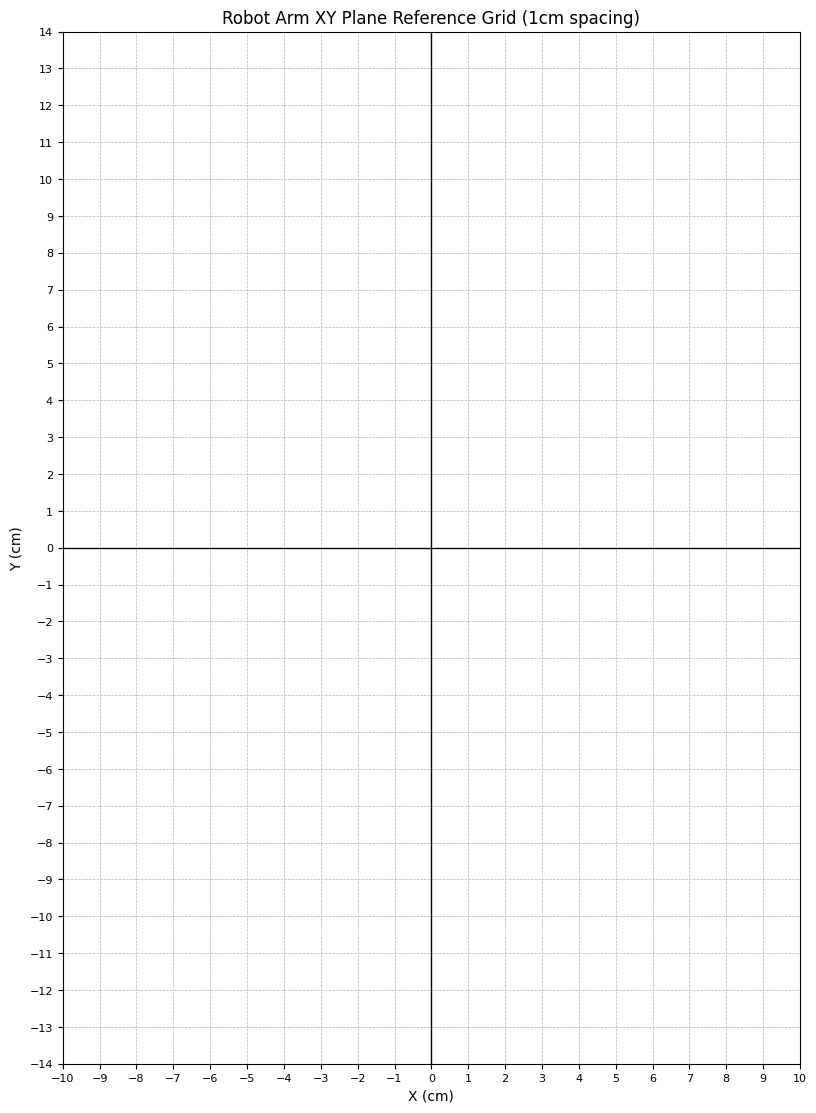

In [ ]:
# Robot Arm Coordinate pad
import matplotlib.pyplot as plt

def plot_xy_grid_for_print():
    fig, ax = plt.subplots(figsize=(8.27, 11.69))  # A4 크기 (inches 기준: 1inch = 2.54cm)

    # x, y 범위 (cm)
    x_range = (-10, 10)
    y_range = (-14, 14)

    # 격자 간격
    step = 1  # 1cm 간격

    # 격자 그리기
    ax.set_xticks([x for x in range(x_range[0], x_range[1] + 1, step)])
    ax.set_yticks([y for y in range(y_range[0], y_range[1] + 1, step)])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # 가운데 원점
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linewidth=1)

    # 축 라벨 및 제목
    ax.set_xlabel("X (cm)")
    ax.set_ylabel("Y (cm)")
    ax.set_title("Robot Arm XY Plane Reference Grid (1cm spacing)")

    # 축 범위 설정
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_aspect('equal')

    # 눈금 글자 크기 조정
    ax.tick_params(labelsize=8)

    # 여백 없애기
    plt.tight_layout()

    # PDF로 저장
    plt.savefig("robot_arm_xy_grid.pdf", dpi=300)
    plt.show()

plot_xy_grid_for_print()
